## Section 0: import and function definitions

In [10]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import pygsp
from pygsp import graphs, filters
import networkx as nx
import pickle
import matplotlib.cm as cm
import pylab
import os

In [3]:
%matplotlib inline

In [4]:
## data folders
data_folder = '../data/'
plots_folder = '../plots/'

In [5]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
def load_object(filename):
    with open(filename, 'rb') as input:
        obj = pickle.load(input)
    return obj

In [7]:
def build_signal(G, views):
    '''
    Given the raw counts based on page views, build the signal on the graph
    :param G:
    :param views:
    :return: dict node to signal (ratio between views before and after the event)
    '''
    views_graph = {}
    for node in G.nodes():
        if node not in views.keys():
            views_graph[node] = 1
            continue
        if len(views[node]) < 2 or views[node][0][0] == 0:
            views_graph[node] = 1
            continue

        try:
            # TODO: assert that dates are before & after the event            
            views_graph[node] = views[node][-1][0] / views[node][0][0]
        except IndexError:
            print(f'IndexError for node {node}')
            views_graph[node] = 1

    return views_graph

In [8]:
def hop_map(distance_source):
    '''
    function that maps number of hops to a list of pages that can be reachable within n_hops from stan lee
    :param distance_source: the number of hops to make from source
    :return: n_hops_to_links
    '''
    hop_links = {}
    for item in distance_source:
        n_hops = distance_source[item]
        if (n_hops in hop_links):
            hop_links[n_hops].append(item)
        else:
            hop_links[n_hops] = [item]
    return hop_links


In [9]:
def assign_coordinates_colours(n_hops_to_links, signal):
    '''
    
    :param n_hops_to_links: dict that maps n_hops to the links
    :param signal: dict that maps article to their signal
    :return: the coordinates of the points and the signal
    '''
    R = list(n_hops_to_links.keys())  #radius
    T = [len(n_hops_to_links[hop]) for hop in R] # how many points per circle
    points = []
    points_signal = []
    r_init = 0
    idx = 0
    for r, t in rtpairs(R, T):
        if r == r_init:
            article = n_hops_to_links[r][idx]
            idx = idx+1
        else:
            article = n_hops_to_links[r][0]
            r_init = r
            idx = 1
        points.append(np.array([r * np.cos(t), r * np.sin(t)]))
        points_signal.append(signal[article])
    points = np.array(points)
    return points, points_signal

In [30]:
def rtpairs(r, n):
    for i in range(len(r)):
        for j in range(n[i]):
            yield r[i], j*(2 * np.pi / n[i])

## Section 1: loading the signal and plotting it

In [31]:
Gnx = nx.read_gpickle(os.path.join(data_folder, 'G_StanLee.gpickle'))
views_Gnx = load_object(os.path.join(data_folder, '1_StanLee_signal.pkl'))

In [32]:
signal_Gnx = build_signal(Gnx, views_Gnx)

In [33]:
source = 'Stan Lee'
distance_stan_lee = nx.shortest_path_length(Gnx, source='Stan Lee')
print('nodes are max ', max(distance_stan_lee.values()), 'hops away from ', source)

nodes are max  5 hops away from  Stan Lee


In [34]:
n_hops_to_links = hop_map(distance_stan_lee)

In [35]:
points, labels = assign_coordinates_colours(n_hops_to_links, signal_Gnx)

/Users/mi/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


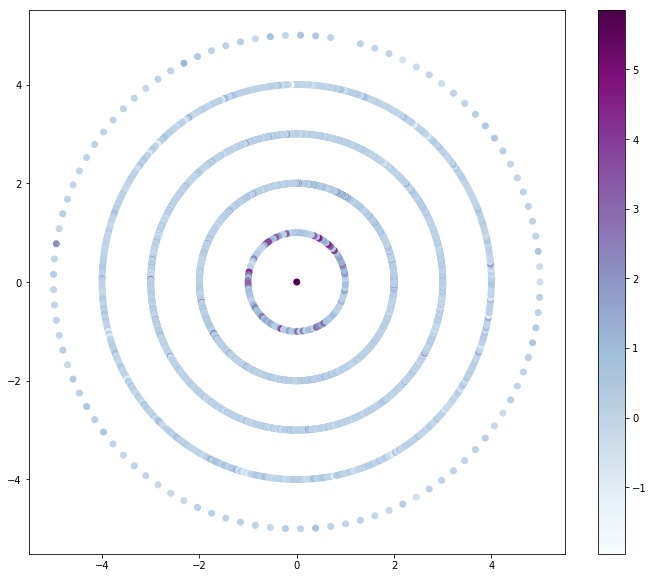

In [36]:
plt.figure(figsize=(12,10))
sc = plt.scatter(points[:,0], points[:,1], c=np.log(labels), cmap=pylab.cm.BuPu)
plt.colorbar(sc)

### Section 2: SP on the signal 

In [37]:
nx.set_node_attributes(Gnx, values= signal_Gnx, name = 'delta')

In [38]:
Gnx.node['Stan Lee']

{'delta': 347.05108962332224}

In [39]:
nodes = np.array(Gnx.nodes())
delta = nx.get_node_attributes(Gnx, 'delta')
signal = np.array([delta[n] for n in nodes])

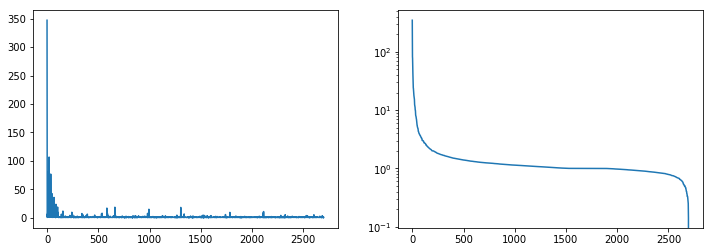

In [40]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(signal)
plt.subplot(1,2,2)
plt.semilogy(sorted(signal, reverse=True))

In [70]:
# look at what pages got the highest delta
list(zip(nodes[signal>10],signal[signal>10]))

[('Stan Lee', 347.05108962332224),
 ('List of American comics creators', 12.5),
 ('Don Heck', 58.83),
 ('Comics Code Authority', 23.620192307692307),
 ('Bullpen Bulletins', 82.42857142857143),
 ('List of comics creators appearing in comics', 106.85714285714286),
 ('DC Comics Presents', 25.19672131147541),
 ('Nick Fury, Agent of S.H.I.E.L.D. (feature)', 22.0),
 ('Bill Everett', 76.96969696969697),
 ('Mystic Comics', 15.727272727272727),
 ('Karakuri Dôji Ultimo', 42.46666666666667),
 ('Martin Goodman (publisher)', 42.62996941896024),
 ('Silver Surfer (comic book)', 12.375),
 ('Joe Simon', 25.946428571428573),
 ('Peter Sanderson', 36.0),
 ('Sol Brodsky', 11.555555555555555),
 ('Inkpot Award', 17.789473684210527),
 ('100 Greatest Marvels of All Time', 16.387755102040817),
 ('Heroman', 23.87012987012987),
 ('Marvel Comics', 10.112600037223153),
 ('List of Harvey Award winners', 16.833333333333332),
 ('DeWitt Clinton High School', 12.126984126984127),
 ('Vincent Fago', 19.0),
 ('Greg Theakst

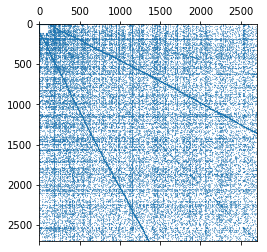

In [42]:
# make graph undirected & remove self loops
A = nx.adjacency_matrix(Gnx).todense()
A = np.logical_or(A, A.T).astype(int)
np.fill_diagonal(A, 0)
A = np.array(A)
adjacency = sparse.csr_matrix(A)

plt.spy(adjacency, markersize=0.1)

In [58]:
n_nodes = A.shape[0]
D = sparse.diags(np.sum(A, axis=0))
D_inv_sq = sparse.diags(1 / np.sqrt(np.sum(A,axis=0)))
laplacian_combinatorial = D - adjacency
laplacian_normalized = sparse.eye(n_nodes) - D_inv_sq @ adjacency @ D_inv_sq.T

In [59]:
#G = pygsp.graphs.Graph(adjacency, lap_type='combinatorial')
G = pygsp.graphs.Graph(sparse.csr_matrix(A), lap_type='normalized')

#eig_val, U = sparse.linalg.eigsh(laplacian_normalized, k=3, which='SM')
eig_val, U = sparse.linalg.eigsh(G.L, k=3, which='SM')
eigenmap = U[:,1:3]

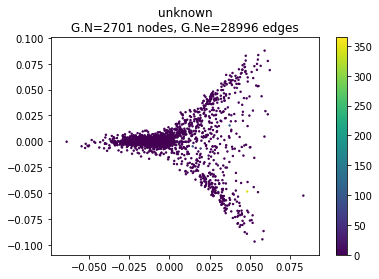

In [60]:
G.set_coordinates(eigenmap)
G.plot_signal(signal, vertex_size=2, show_edges=False)
#plt.scatter(U[:, 1], U[:, 2], s=1)

In [61]:
eigenval_comb, eigen_vec_comb = np.linalg.eigh(laplacian_combinatorial.toarray())

In [62]:
def GFT(x):
    U = eigen_vec_comb
    return  np.matmul(U.T,x) # U.T= U^-1 because orthonormal 

def iGFT(x):
    U = eigen_vec_comb
    return np.matmul(U,x) 

def heat_kernel(e, t):
    return np.exp(-t*e)

def inverse_kernel(e, t):
    g = 1/(1 + t*e)
    return g

def rectangle_kernel(e, l_min, l_max):
    cond = np.logical_and(e >= l_min, e <= l_max)
    return np.where(cond, 1, 0)

def graph_filter(x, kernel, **kwargs):
    e = eigenval_comb
    g = kernel(e, **kwargs)
    return iGFT(np.matmul(np.diag(g),GFT(x)))

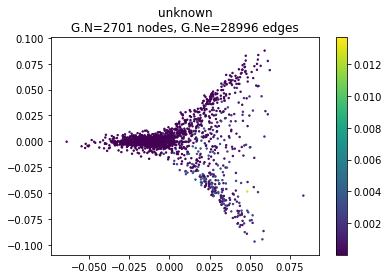

In [67]:
dirac = np.zeros(n_nodes);
dirac[nodes=='Stan Lee'] = 1;
x = graph_filter(dirac, heat_kernel, t=0.02)
G.plot_signal(x, vertex_size=2, show_edges=False)

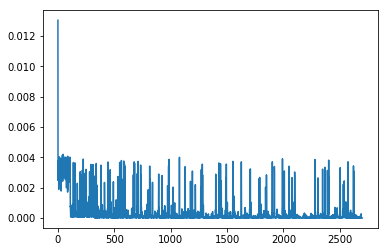

In [68]:
plt.plot(x)